In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract

In [6]:

image = cv2.imread(
  filename='D:\\datascience\\donor\\img\\141899 .jpg',
  flags=cv2.IMREAD_COLOR,
)

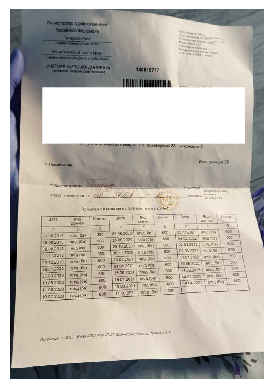

In [10]:
def show_image(img, **kwargs):
    """
    Show an RGB numpy array of an image without any interpolation
    """
    plt.subplot()
    plt.axis('off')
    plt.imshow(
        X=img,
        interpolation='none',
        **kwargs
    )
show_image(image)

In [7]:
class TableLinesRemover:

    def __init__(self, image):
        self.image = image

    def execute(self):
        self.grayscale_image()
        self.store_process_image("0_grayscaled.jpg", self.grey)
        self.threshold_image()
        self.store_process_image("1_thresholded.jpg", self.thresholded_image)
        self.invert_image()
        self.store_process_image("2_inverted.jpg", self.inverted_image)
        self.erode_vertical_lines()
        self.store_process_image("3_erode_vertical_lines.jpg", self.vertical_lines_eroded_image)
        self.erode_horizontal_lines()
        self.store_process_image("4_erode_horizontal_lines.jpg", self.horizontal_lines_eroded_image)
        self.combine_eroded_images()
        self.store_process_image("5_combined_eroded_images.jpg", self.combined_image)
        self.dilate_combined_image_to_make_lines_thicker()
        self.store_process_image("6_dilated_combined_image.jpg", self.combined_image_dilated)
        self.subtract_combined_and_dilated_image_from_original_image()
        self.store_process_image("7_image_without_lines.jpg", self.image_without_lines)
        self.remove_noise_with_erode_and_dilate()
        self.store_process_image("8_image_without_lines_noise_removed.jpg", self.image_without_lines_noise_removed)
        return self.image_without_lines_noise_removed

    def grayscale_image(self):
        self.grey = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    def threshold_image(self):
        self.thresholded_image = cv2.threshold(self.grey, 127, 255, cv2.THRESH_BINARY)[1]

    def invert_image(self):
        self.inverted_image = cv2.bitwise_not(self.thresholded_image)

    def erode_vertical_lines(self):
        hor = np.array([[1,1,1,1,1,1]])
        self.vertical_lines_eroded_image = cv2.erode(self.inverted_image, hor, iterations=10)
        self.vertical_lines_eroded_image = cv2.dilate(self.vertical_lines_eroded_image, hor, iterations=10)

    def erode_horizontal_lines(self):
        ver = np.array([[1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1]])
        self.horizontal_lines_eroded_image = cv2.erode(self.inverted_image, ver, iterations=10)
        self.horizontal_lines_eroded_image = cv2.dilate(self.horizontal_lines_eroded_image, ver, iterations=10)

    def combine_eroded_images(self):
        self.combined_image = cv2.add(self.vertical_lines_eroded_image, self.horizontal_lines_eroded_image)

    def dilate_combined_image_to_make_lines_thicker(self):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        self.combined_image_dilated = cv2.dilate(self.combined_image, kernel, iterations=5)

    def subtract_combined_and_dilated_image_from_original_image(self):
        self.image_without_lines = cv2.subtract(self.inverted_image, self.combined_image_dilated)

    def remove_noise_with_erode_and_dilate(self):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        self.image_without_lines_noise_removed = cv2.erode(self.image_without_lines, kernel, iterations=1)
        self.image_without_lines_noise_removed = cv2.dilate(self.image_without_lines_noise_removed, kernel, iterations=1)

    def store_process_image(self, file_name, image):
        path = "./process_images/table_lines_remover/" + file_name
        cv2.imwrite(path, image)

In [8]:
result = TableLinesRemover(image)

In [14]:
class TableExtractor:

    def __init__(self, image_path):
        self.image_path = image_path

    def execute(self):
        self.read_image()
        self.store_process_image("0_original.jpg", self.image)
        self.convert_image_to_grayscale()
        self.store_process_image("1_grayscaled.jpg", self.grayscale_image)
        self.threshold_image()
        self.store_process_image("3_thresholded.jpg", self.thresholded_image)
        self.invert_image()
        self.store_process_image("4_inverteded.jpg", self.inverted_image)
        self.dilate_image()
        self.store_process_image("5_dialateded.jpg", self.dilated_image)
        self.find_contours()
        self.store_process_image("6_all_contours.jpg", self.image_with_all_contours)
        self.filter_contours_and_leave_only_rectangles()
        self.store_process_image("7_only_rectangular_contours.jpg", self.image_with_only_rectangular_contours)
        self.find_largest_contour_by_area()
        self.store_process_image("8_contour_with_max_area.jpg", self.image_with_contour_with_max_area)
        self.order_points_in_the_contour_with_max_area()
        self.store_process_image("9_with_4_corner_points_plotted.jpg", self.image_with_points_plotted)
        self.calculate_new_width_and_height_of_image()
        self.apply_perspective_transform()
        self.store_process_image("10_perspective_corrected.jpg", self.perspective_corrected_image)
        self.add_10_percent_padding()
        self.store_process_image("11_perspective_corrected_with_padding.jpg", self.perspective_corrected_image_with_padding)
        return self.perspective_corrected_image_with_padding

    def read_image(self):
        self.image = cv2.imread(self.image_path)

    def convert_image_to_grayscale(self):
        self.grayscale_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    def blur_image(self):
        self.blurred_image = cv2.blur(self.grayscale_image, (5, 5))

    def threshold_image(self):
        self.thresholded_image = cv2.threshold(self.grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    def invert_image(self):
        self.inverted_image = cv2.bitwise_not(self.thresholded_image)

    def dilate_image(self):
        self.dilated_image = cv2.dilate(self.inverted_image, None, iterations=5)

    def find_contours(self):
        self.contours, self.hierarchy = cv2.findContours(self.dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        self.image_with_all_contours = self.image.copy()
        cv2.drawContours(self.image_with_all_contours, self.contours, -1, (0, 255, 0), 3)

    def filter_contours_and_leave_only_rectangles(self):
        self.rectangular_contours = []
        for contour in self.contours:
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
            if len(approx) == 4:
                self.rectangular_contours.append(approx)
        self.image_with_only_rectangular_contours = self.image.copy()
        cv2.drawContours(self.image_with_only_rectangular_contours, self.rectangular_contours, -1, (0, 255, 0), 3)

    def find_largest_contour_by_area(self):
        max_area = 0
        self.contour_with_max_area = None
        for contour in self.rectangular_contours:
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                self.contour_with_max_area = contour
        self.image_with_contour_with_max_area = self.image.copy()
        cv2.drawContours(self.image_with_contour_with_max_area, [self.contour_with_max_area], -1, (0, 255, 0), 3)

    def order_points_in_the_contour_with_max_area(self):
        self.contour_with_max_area_ordered = self.order_points(self.contour_with_max_area)
        self.image_with_points_plotted = self.image.copy()
        for point in self.contour_with_max_area_ordered:
            point_coordinates = (int(point[0]), int(point[1]))
            self.image_with_points_plotted = cv2.circle(self.image_with_points_plotted, point_coordinates, 10, (0, 0, 255), -1)

    def calculate_new_width_and_height_of_image(self):
        existing_image_width = self.image.shape[1]
        existing_image_width_reduced_by_10_percent = int(existing_image_width * 0.9)
        
        distance_between_top_left_and_top_right = self.calculateDistanceBetween2Points(self.contour_with_max_area_ordered[0], self.contour_with_max_area_ordered[1])
        distance_between_top_left_and_bottom_left = self.calculateDistanceBetween2Points(self.contour_with_max_area_ordered[0], self.contour_with_max_area_ordered[3])

        aspect_ratio = distance_between_top_left_and_bottom_left / distance_between_top_left_and_top_right

        self.new_image_width = existing_image_width_reduced_by_10_percent
        self.new_image_height = int(self.new_image_width * aspect_ratio)

    def apply_perspective_transform(self):
        pts1 = np.float32(self.contour_with_max_area_ordered)
        pts2 = np.float32([[0, 0], [self.new_image_width, 0], [self.new_image_width, self.new_image_height], [0, self.new_image_height]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        self.perspective_corrected_image = cv2.warpPerspective(self.image, matrix, (self.new_image_width, self.new_image_height))

    def add_10_percent_padding(self):
        image_height = self.image.shape[0]
        padding = int(image_height * 0.1)
        self.perspective_corrected_image_with_padding = cv2.copyMakeBorder(self.perspective_corrected_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    def draw_contours(self):
        self.image_with_contours = self.image.copy()
        cv2.drawContours(self.image_with_contours,  [ self.contour_with_max_area ], -1, (0, 255, 0), 1)

    def calculateDistanceBetween2Points(self, p1, p2):
        dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
        return dis
    
    def order_points(self, pts):
        # initialzie a list of coordinates that will be ordered
        # such that the first entry in the list is the top-left,
        # the second entry is the top-right, the third is the
        # bottom-right, and the fourth is the bottom-left
        pts = pts.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")

        # the top-left point will have the smallest sum, whereas
        # the bottom-right point will have the largest sum
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]

        # now, compute the difference between the points, the
        # top-right point will have the smallest difference,
        # whereas the bottom-left will have the largest difference
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        # return the ordered coordinates
        return rect
    
    def store_process_image(self, file_name, image):
        path = "./process_images/table_extractor/" + file_name
        cv2.imwrite(path, image)
q = TableExtractor(result)
        

In [16]:
import subprocess

class OcrToTableTool:

    def __init__(self, image, original_image):
        self.thresholded_image = image
        self.original_image = original_image

    def execute(self):
        self.dilate_image()
        self.store_process_image('0_dilated_image.jpg', self.dilated_image)
        self.find_contours()
        self.store_process_image('1_contours.jpg', self.image_with_contours_drawn)
        self.convert_contours_to_bounding_boxes()
        self.store_process_image('2_bounding_boxes.jpg', self.image_with_all_bounding_boxes)
        self.mean_height = self.get_mean_height_of_bounding_boxes()
        self.sort_bounding_boxes_by_y_coordinate()
        self.club_all_bounding_boxes_by_similar_y_coordinates_into_rows()
        self.sort_all_rows_by_x_coordinate()
        self.crop_each_bounding_box_and_ocr()
        self.generate_csv_file()

    def threshold_image(self):
        return cv2.threshold(self.grey_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    def convert_image_to_grayscale(self):
        return cv2.cvtColor(self.image, self.dilated_image)

    def dilate_image(self):
        kernel_to_remove_gaps_between_words = np.array([
                [1,1,1,1,1,1,1,1,1,1],
               [1,1,1,1,1,1,1,1,1,1]
        ])
        self.dilated_image = cv2.dilate(self.thresholded_image, kernel_to_remove_gaps_between_words, iterations=5)
        simple_kernel = np.ones((5,5), np.uint8)
        self.dilated_image = cv2.dilate(self.dilated_image, simple_kernel, iterations=2)
    
    def find_contours(self):
        result = cv2.findContours(self.dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        self.contours = result[0]
        self.image_with_contours_drawn = self.original_image.copy()
        cv2.drawContours(self.image_with_contours_drawn, self.contours, -1, (0, 255, 0), 3)
    
    def approximate_contours(self):
        self.approximated_contours = []
        for contour in self.contours:
            approx = cv2.approxPolyDP(contour, 3, True)
            self.approximated_contours.append(approx)

    def draw_contours(self):
        self.image_with_contours = self.original_image.copy()
        cv2.drawContours(self.image_with_contours, self.approximated_contours, -1, (0, 255, 0), 5)

    def convert_contours_to_bounding_boxes(self):
        self.bounding_boxes = []
        self.image_with_all_bounding_boxes = self.original_image.copy()
        for contour in self.contours:
            x, y, w, h = cv2.boundingRect(contour)
            self.bounding_boxes.append((x, y, w, h))
            self.image_with_all_bounding_boxes = cv2.rectangle(self.image_with_all_bounding_boxes, (x, y), (x + w, y + h), (0, 255, 0), 5)

    def get_mean_height_of_bounding_boxes(self):
        heights = []
        for bounding_box in self.bounding_boxes:
            x, y, w, h = bounding_box
            heights.append(h)
        return np.mean(heights)

    def sort_bounding_boxes_by_y_coordinate(self):
        self.bounding_boxes = sorted(self.bounding_boxes, key=lambda x: x[1])

    def club_all_bounding_boxes_by_similar_y_coordinates_into_rows(self):
        self.rows = []
        half_of_mean_height = self.mean_height / 2
        current_row = [ self.bounding_boxes[0] ]
        for bounding_box in self.bounding_boxes[1:]:
            current_bounding_box_y = bounding_box[1]
            previous_bounding_box_y = current_row[-1][1]
            distance_between_bounding_boxes = abs(current_bounding_box_y - previous_bounding_box_y)
            if distance_between_bounding_boxes <= half_of_mean_height:
                current_row.append(bounding_box)
            else:
                self.rows.append(current_row)
                current_row = [ bounding_box ]
        self.rows.append(current_row)

    def sort_all_rows_by_x_coordinate(self):
        for row in self.rows:
            row.sort(key=lambda x: x[0])

    def crop_each_bounding_box_and_ocr(self):
        self.table = []
        current_row = []
        image_number = 0
        for row in self.rows:
            for bounding_box in row:
                x, y, w, h = bounding_box
                y = y - 5
                cropped_image = self.original_image[y:y+h, x:x+w]
                image_slice_path = "./ocr_slices/img_" + str(image_number) + ".jpg"
                cv2.imwrite(image_slice_path, cropped_image)
                results_from_ocr = self.get_result_from_tersseract(image_slice_path)
                current_row.append(results_from_ocr)
                image_number += 1
            self.table.append(current_row)
            current_row = []

    def get_result_from_tersseract(self, image_path):
        output = subprocess.getoutput('tesseract ' + image_path + ' - -l eng --oem 3 --psm 7 --dpi 72 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789().calmg* "')
        output = output.strip()
        return output

    def generate_csv_file(self):
        with open("output.csv", "w") as f:
            for row in self.table:
                f.write(",".join(row) + "\n")

    def store_process_image(self, file_name, image):
        path = "./process_images/ocr_table_tool/" + file_name
        cv2.imwrite(path, image)
result = OcrToTableTool(image)

TypeError: OcrToTableTool.__init__() missing 1 required positional argument: 'original_image'